<a href="https://colab.research.google.com/github/CameronBannick/Sales_Predictions/blob/main/05_Sales_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

## Modules

In [1]:
#standard imports 
import pandas as pd
import numpy as np
import pingouin as pg 
#data visualization impports
import matplotlib.pyplot as plt
import seaborn as sns
#sklearn imports
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn import set_config
set_config(display='diagram')
#xgboost import
import xgboost as xgb
#tensorflow imports
from tensorflow.keras import Sequential
from tensorflow.keras import metrics
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
#statistical imports
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import pearsonr
from scipy.stats import shapiro, levene
from scipy.stats import boxcox
from scipy.stats import f_oneway

## Data

In [2]:
#save filepath as variable
filename = 'DATA/sales_predictions.csv'
#import data with pandas
df = pd.read_csv(filename)
#inspect data
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


# Data inspection and validation

In [3]:
#call info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [4]:
#make all feature names lowercase
df.columns = [x.lower() for x in df.columns]
#inspect data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   item_identifier            8523 non-null   object 
 1   item_weight                7060 non-null   float64
 2   item_fat_content           8523 non-null   object 
 3   item_visibility            8523 non-null   float64
 4   item_type                  8523 non-null   object 
 5   item_mrp                   8523 non-null   float64
 6   outlet_identifier          8523 non-null   object 
 7   outlet_establishment_year  8523 non-null   int64  
 8   outlet_size                6113 non-null   object 
 9   outlet_location_type       8523 non-null   object 
 10  outlet_type                8523 non-null   object 
 11  item_outlet_sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [5]:
#inspect duplicate data
df.duplicated().sum()

0

In [6]:
#inspect missing data
df.isna().sum().sum()

3873

### item_fat_content

In [7]:
#inspecting values for item_fat_content
df['item_fat_content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: item_fat_content, dtype: int64

In [8]:
#reverting redundant values for consistency
df['item_fat_content'] = df['item_fat_content'].replace('LF', 'Low Fat')
df['item_fat_content'] = df['item_fat_content'].replace('low fat', 'Low Fat')
df['item_fat_content'] = df['item_fat_content'].replace('reg', 'Regular')
df['item_fat_content'].value_counts()

Low Fat    5517
Regular    3006
Name: item_fat_content, dtype: int64

### item_type

In [9]:
#inspecting values for item_type 
df['item_type'].value_counts()

Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: item_type, dtype: int64

### outlet_establishment_year

In [10]:
#inspecting values for year
df['outlet_establishment_year'].value_counts()

1985    1463
1987     932
1999     930
1997     930
2004     930
2002     929
2009     928
2007     926
1998     555
Name: outlet_establishment_year, dtype: int64

In [11]:
#change to string 
df['outlet_establishment_year']=df['outlet_establishment_year'].astype('object')
#call info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   item_identifier            8523 non-null   object 
 1   item_weight                7060 non-null   float64
 2   item_fat_content           8523 non-null   object 
 3   item_visibility            8523 non-null   float64
 4   item_type                  8523 non-null   object 
 5   item_mrp                   8523 non-null   float64
 6   outlet_identifier          8523 non-null   object 
 7   outlet_establishment_year  8523 non-null   object 
 8   outlet_size                6113 non-null   object 
 9   outlet_location_type       8523 non-null   object 
 10  outlet_type                8523 non-null   object 
 11  item_outlet_sales          8523 non-null   float64
dtypes: float64(4), object(8)
memory usage: 799.2+ KB


### outlet_size

In [12]:
#inspect values in outlet_size
df['outlet_size'].value_counts()

Medium    2793
Small     2388
High       932
Name: outlet_size, dtype: int64

### outlet_location_type

In [13]:
#inspect values in outlet_location_type
df['outlet_location_type'].value_counts()

Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: outlet_location_type, dtype: int64

### outlet_type

In [14]:
#inspect values in outlet type
df['outlet_type'].value_counts()

Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: outlet_type, dtype: int64

# Exploratory data analysis

## Item information

### Item outlet sales

In [15]:
#call describe on outlet sales
df['item_outlet_sales'].describe().round(2)

count     8523.00
mean      2181.29
std       1706.50
min         33.29
25%        834.25
50%       1794.33
75%       3101.30
max      13086.96
Name: item_outlet_sales, dtype: float64

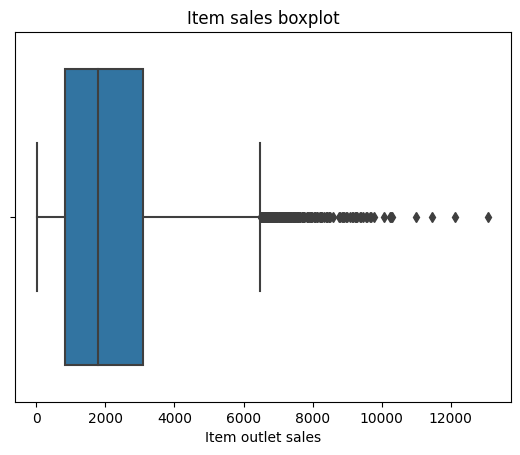

In [16]:
#call boxplot
g = sns.boxplot(x='item_outlet_sales', data=df)
#call title
g.set_title('Item sales boxplot')
#call axis label
plt.xlabel('Item outlet sales')
#save plot
#plt.savefig('Item_sales_boxplot')
#show plot
plt.show()

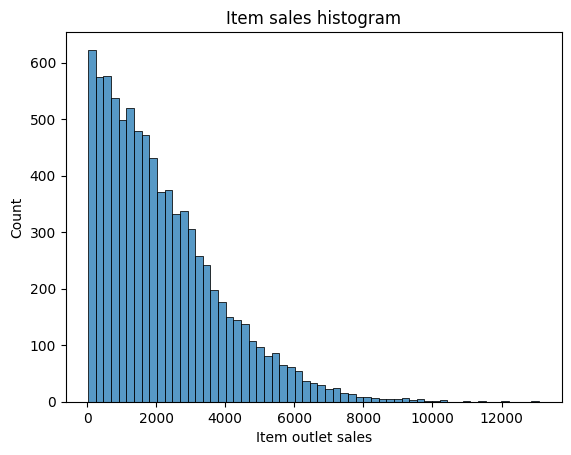

In [17]:
#call histogram
g = sns.histplot(x='item_outlet_sales', data=df)
#call title
g.set_title('Item sales histogram')
#call axis label
plt.xlabel('Item outlet sales')
#save plot
#plt.savefig('Item_sales_histogram')
#show plot
plt.show()

On average, each item sales are 2181.29. The median is 1794.33, implying many outliers which can be seen in the box plot. Most of sales fall between 834.25 and 3101.30

### Item MRP

In [18]:
#call describe on mrp
df['item_mrp'].describe().round(2)

count    8523.00
mean      140.99
std        62.28
min        31.29
25%        93.83
50%       143.01
75%       185.64
max       266.89
Name: item_mrp, dtype: float64

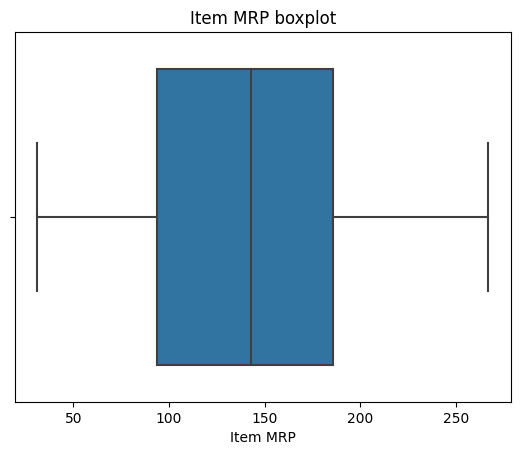

In [19]:
#call boxplot
g = sns.boxplot(x='item_mrp', data=df)
#call title
g.set_title('Item MRP boxplot')
#call axis label
plt.xlabel('Item MRP')
#save plot
#plt.savefig('Item_MRP_boxplot')
#show plot
plt.show()

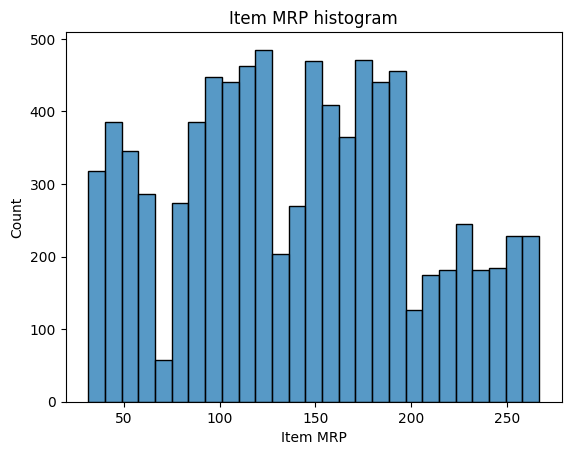

In [20]:
#call histogram
g = sns.histplot(x='item_mrp', data=df)
#call title
g.set_title('Item MRP histogram')
#call axis label
plt.xlabel('Item MRP')
#save plot
#plt.savefig('Item_MRP_histogram')
#show plot
plt.show()

On average, each item sells for 140.99. The median (middle) is at 143.01. Since the median and average are so close to each other, there are little to no outliers. No outliers are displayed in the boxplot. Most of the items sell between 93.83 and 185.64

### Item outlet sales & Item MRP

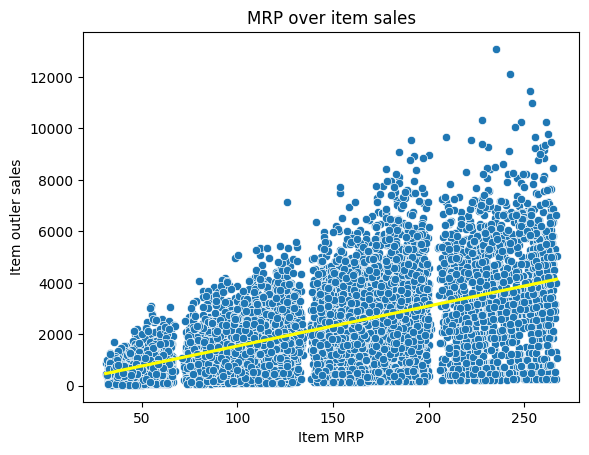

In [21]:
#call sns scatterplot
sns.scatterplot(x='item_mrp', y='item_outlet_sales', data=df)
#call sns regplot
sns.regplot(x='item_mrp', y='item_outlet_sales', data=df, scatter=False, ci=None, line_kws={'color': 'yellow', 'label': 'Correlation Line'})
#call title
plt.title('MRP over item sales')
#call axis title
plt.xlabel('Item MRP')
plt.ylabel('Item outler sales')
#save plot
#plt.savefig('Item_mrp_outlet_sales')
#show plot
plt.show()

In [22]:
#save correlation coefficient
corrco, _ = pearsonr(df['item_mrp'], df['item_outlet_sales'])
#print correlation coefficent 
print(f'Correlation Cooeficient: {corrco:.2f}')

Correlation Cooeficient: 0.57


There is a moderate positive linear correlation between item outlet sales and item mrp. Implying the more expensive the product the more cash it brings it.

### Item visibility 

In [23]:
#call describe on item visibility
df['item_visibility'].describe()

count    8523.000000
mean        0.066132
std         0.051598
min         0.000000
25%         0.026989
50%         0.053931
75%         0.094585
max         0.328391
Name: item_visibility, dtype: float64

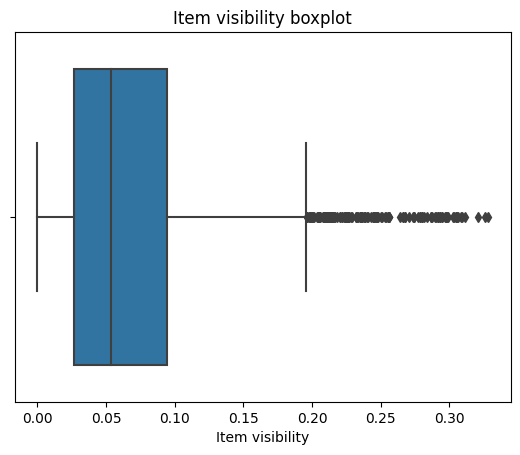

In [24]:
#call boxplot
g = sns.boxplot(x='item_visibility', data=df)
#call title
g.set_title('Item visibility boxplot')
#call axis label
plt.xlabel('Item visibility')
#save plot
#plt.savefig('item_visibility_boxplot')
#show plot
plt.show()

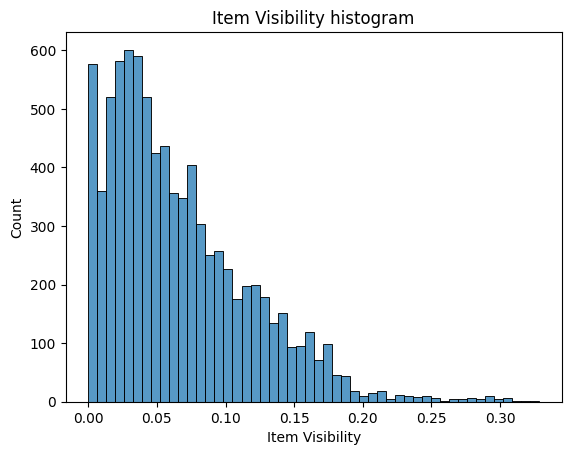

In [25]:
#call histogram
g = sns.histplot(x='item_visibility', data=df)
#call title
g.set_title('Item Visibility histogram')
#call axis label
plt.xlabel('Item Visibility')
#save plot
#plt.savefig('item_visibility_histogram')
#show plot
plt.show()

On average, the items have a visibility of 0.066132. The median (middle) is 0.053931. The average and median are close, but there are a lot of outliers shown on the boxplot. 

### Item visibility and outlet sales

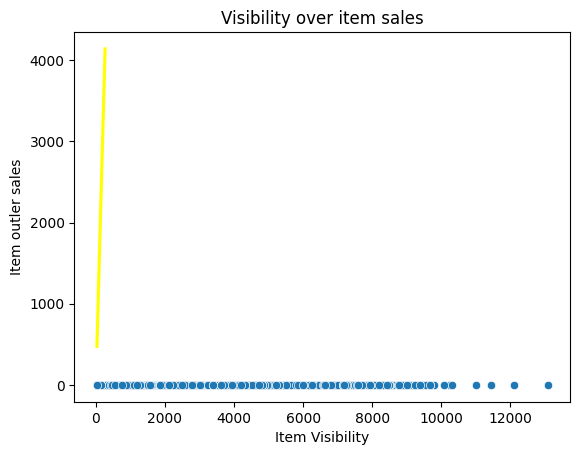

In [26]:
#call sns scatterplot
sns.scatterplot(y='item_visibility', x='item_outlet_sales', data=df)
#call sns regplot
sns.regplot(x='item_mrp', y='item_outlet_sales', data=df, scatter=False, ci=None, line_kws={'color': 'yellow', 'label': 'Correlation Line'})
#call title
plt.title('Visibility over item sales')
#call axis title
plt.xlabel('Item Visibility')
plt.ylabel('Item outler sales')
#save plot
#plt.savefig('item_visibility_item_sales')
#show plot
plt.show()

In [27]:
#save correlation coefficient
corrco, _ = pearsonr(df['item_visibility'], df['item_outlet_sales'])
#print correlation coefficent 
print(f'Correlation Cooeficient: {corrco:.2f}')

Correlation Cooeficient: -0.13


There appears to be no relationship between Item outlet sales and item visibility

### Item weight

In [28]:
#call describe on weight
df['item_weight'].describe()

count    7060.000000
mean       12.857645
std         4.643456
min         4.555000
25%         8.773750
50%        12.600000
75%        16.850000
max        21.350000
Name: item_weight, dtype: float64

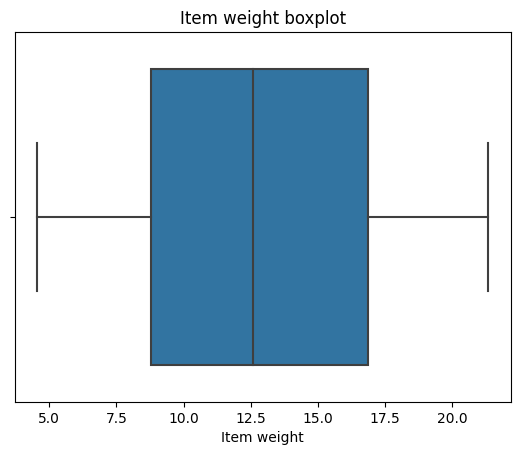

In [29]:
#call boxplot
g = sns.boxplot(x='item_weight', data=df)
#call title
g.set_title('Item weight boxplot')
#call axis label
plt.xlabel('Item weight')
#save plot
#plt.savefig('item_weight_boxplot')
#show plot
plt.show()

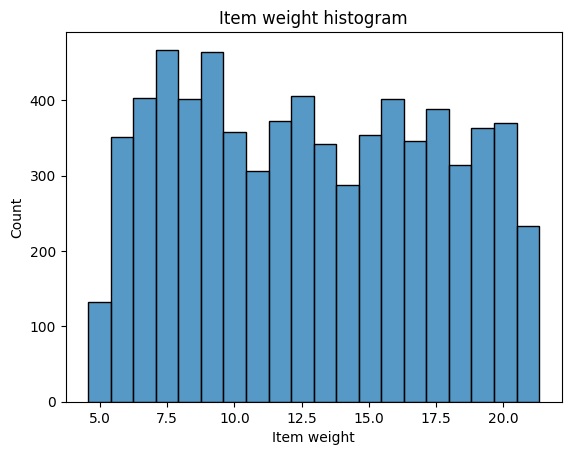

In [30]:
#call histogram
g = sns.histplot(x='item_weight', data=df)
#call title
g.set_title('Item weight histogram')
#call axis label
plt.xlabel('Item weight')
#save plot
#plt.savefig('item_weight_histogram')
#show plot
plt.show()

The items on average weight about 12.8 while the median is about 12.6, implying low to no outliers. We see no outliers in the boxplot above. Most items weigh between 8.7 and 16.8lbs. 

### Item weight and sales

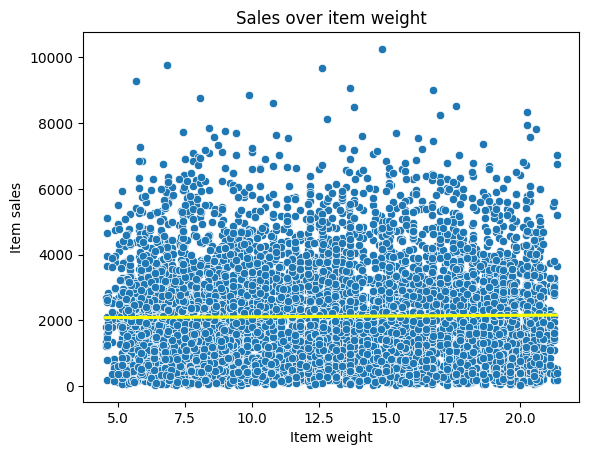

In [31]:
#call sns scatterplot
sns.scatterplot(x='item_weight', y='item_outlet_sales', data=df)
#call sns regplot
sns.regplot(x='item_weight', y='item_outlet_sales', data=df, scatter=False, ci=None, line_kws={'color': 'yellow', 'label': 'Correlation Line'})
#call title
plt.title('Sales over item weight')
#call axis title
plt.xlabel('Item weight')
plt.ylabel('Item sales')
#save plot
#plt.savefig('sales_over_weight')
#show plot
plt.show()

There appears to be no correlation between item weight and sales.

### Item type

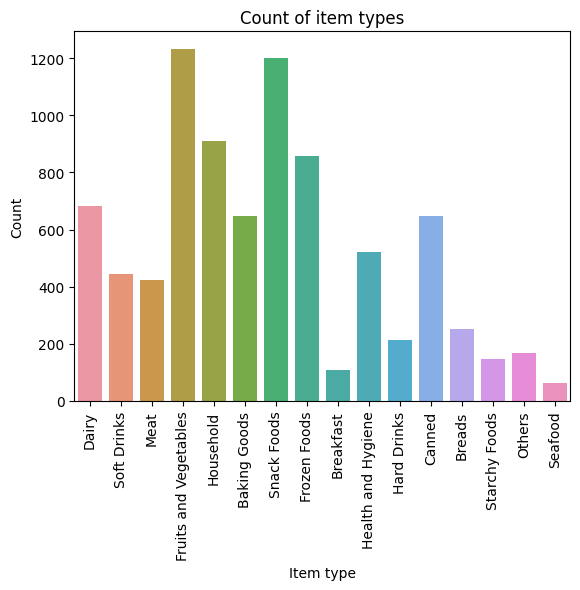

In [32]:
#call sns countplot
g = sns.countplot(x='item_type', data=df)
#call title
g.set_title('Count of item types')
#rotate x ticks
plt.xticks(rotation=90)
#set axis labels
plt.xlabel('Item type')
plt.ylabel('Count')
#save plot
#plt.savefig('item_count')
#show plot
plt.show()

The most items in stock are fruits and vegetables, snack foods, and household products


In [33]:
#groupby item sales avg and type
type_sales_avg = df.groupby('item_type')['item_outlet_sales'].mean()
#groupby item sales sum and type
type_sales_sum = df.groupby('item_type')['item_outlet_sales'].sum()

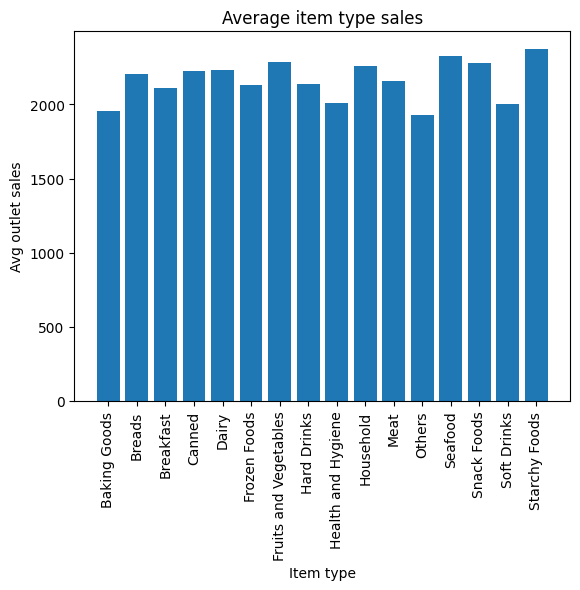

In [34]:
#call plt bar
plt.bar(type_sales_avg.index, type_sales_avg.values)
#call plot title
plt.title('Average item type sales')
#rotate x ticks
plt.xticks(rotation=90)
#call axis lables
plt.xlabel('Item type')
plt.ylabel('Avg outlet sales')
#save plot
#plt.savefig('avg_item_type_sales')
#show plot
plt.show()

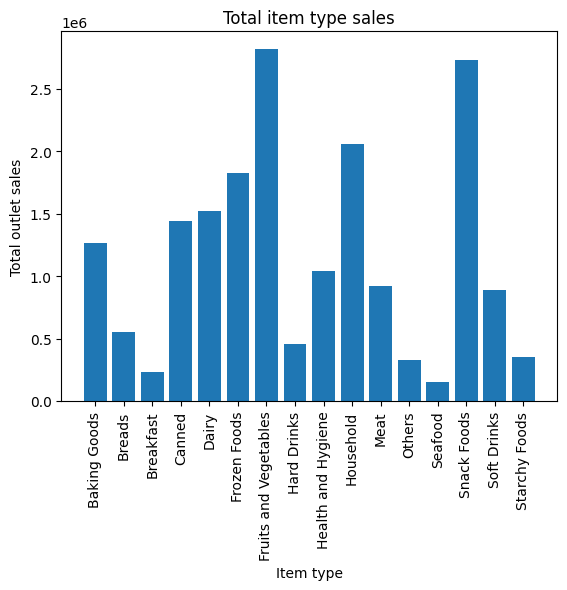

In [35]:
#call plt bar
plt.bar(type_sales_sum.index, type_sales_sum.values)
#call plot title
plt.title('Total item type sales')
#rotate x ticks
plt.xticks(rotation=90)
#call axis lables
plt.xlabel('Item type')
plt.ylabel('Total outlet sales')
#save plot
#plt.savefig('total_item_type_sales')
#show plot
plt.show()

On average, all products dance around 2000 dollars. However, in total, the top 3 are fruits and vegetables, snack foods, and household products.

### Item fat content

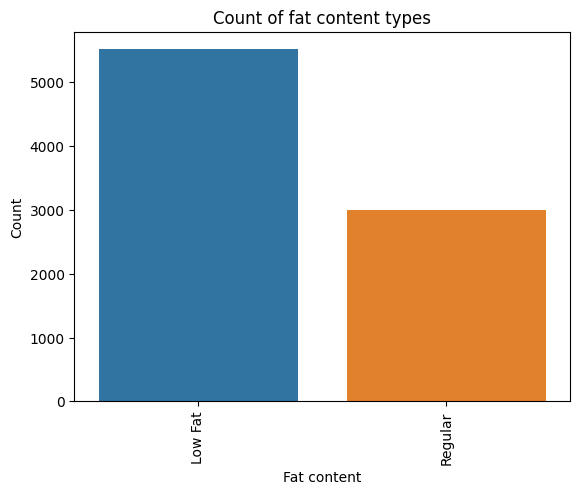

In [36]:
#call sns countplot
g = sns.countplot(x='item_fat_content', data=df)
#call title
g.set_title('Count of fat content types')
#rotate x ticks
plt.xticks(rotation=90)
#set axis labels
plt.xlabel('Fat content')
plt.ylabel('Count')
#save plot
#plt.savefig('fat_content_count')
#show plot
plt.show()

The outlets carry almost double the low fat products as regular ones.

In [37]:
#groupby item sales avg and fat content
fat_sales_avg = df.groupby('item_fat_content')['item_outlet_sales'].mean()
#groupby item sales sum and fat content
fat_sales_sum = df.groupby('item_fat_content')['item_outlet_sales'].sum()

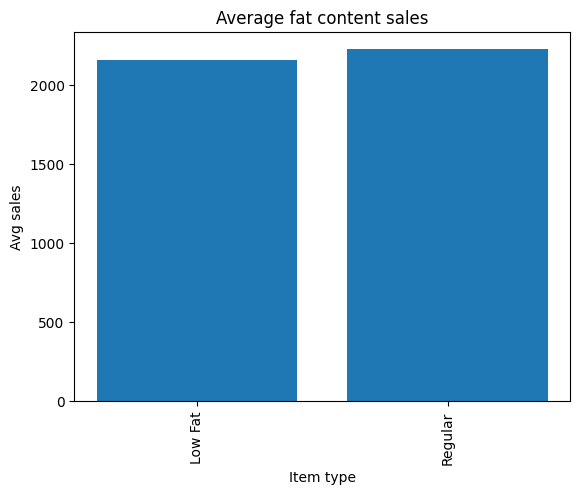

In [38]:
#call plt bar
plt.bar(fat_sales_avg.index, fat_sales_avg.values)
#call plot title
plt.title('Average fat content sales')
#rotate x ticks
plt.xticks(rotation=90)
#call axis lables
plt.xlabel('Item type')
plt.ylabel('Avg sales')
#save plot
#plt.savefig('fat_content_avg_sales')
#show plot
plt.show()

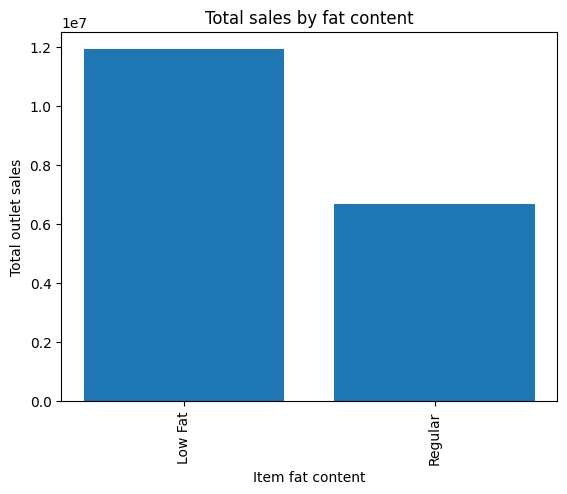

In [39]:
#call plt bar
plt.bar(fat_sales_sum.index, fat_sales_sum.values)
#call plot title
plt.title('Total sales by fat content')
#rotate x ticks
plt.xticks(rotation=90)
#call axis lables
plt.xlabel('Item fat content')
plt.ylabel('Total outlet sales')
#save plot
#plt.savefig('fat_content_total_sales')
#show plot
plt.show()

On average, low fat and regular fat items sell the same. But, in total, low fat has sold around more than double of regular.

## Store information

### Outlet establishment year

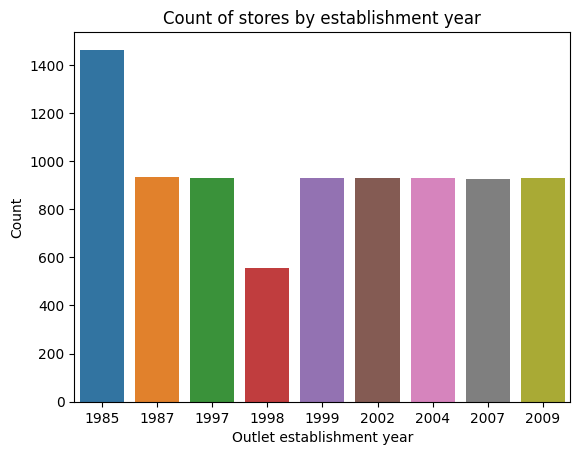

In [40]:
#call sns countplot
g = sns.countplot(x='outlet_establishment_year', data=df)
#set title
g.set_title('Count of stores by establishment year')
#set axis labels
plt.xlabel('Outlet establishment year')
plt.ylabel('Count')
#save plot
#plt.savefig('count_of_stores_year')
#show plot
plt.show()

Most of the outlets opened in 1985 and the least amount in 1998.

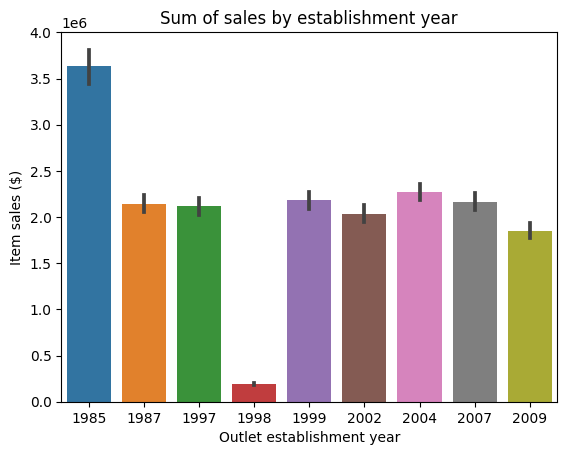

In [41]:
#call sns countplot
g = sns.barplot(x='outlet_establishment_year', y='item_outlet_sales', data=df, estimator=np.sum)
#set title
g.set_title('Sum of sales by establishment year')
#set axis labels
plt.xlabel('Outlet establishment year')
plt.ylabel('Item sales ($)')
#save plot
#plt.savefig('total_sales_stores_year')
#show plot
plt.show()

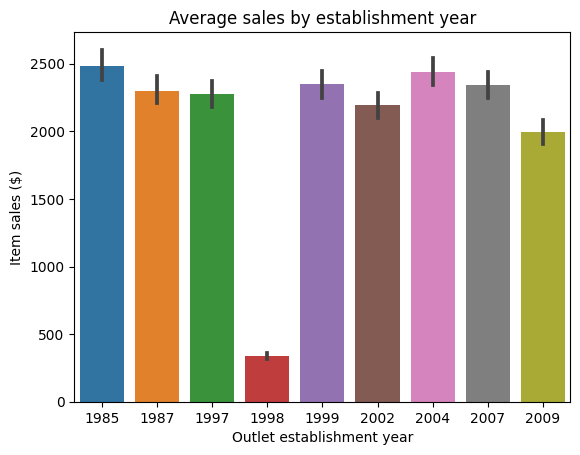

In [42]:
#call sns countplot
g = sns.barplot(x='outlet_establishment_year', y='item_outlet_sales', data=df, estimator=np.mean)
#set title
g.set_title('Average sales by establishment year')
#set axis labels
plt.xlabel('Outlet establishment year')
plt.ylabel('Item sales ($)')
#save plot
#plt.savefig('average_sales_stores_year')
#show plot
plt.show()

The highest sum of sales was in 1985 and lowest in 1998. On average it is the same.

### Outlet size

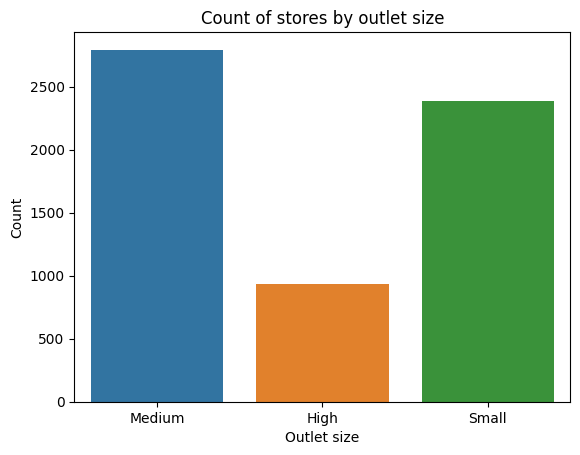

In [43]:
#call sns countplot
g = sns.countplot(x='outlet_size', data=df)
#set title
g.set_title('Count of stores by outlet size')
#set axis labels
plt.xlabel('Outlet size')
plt.ylabel('Count')
#save plot
#plt.savefig('store_count_size')
#show plot
plt.show()

Most outlets are a medium size following a small size. There is a relatively low amount of large size.

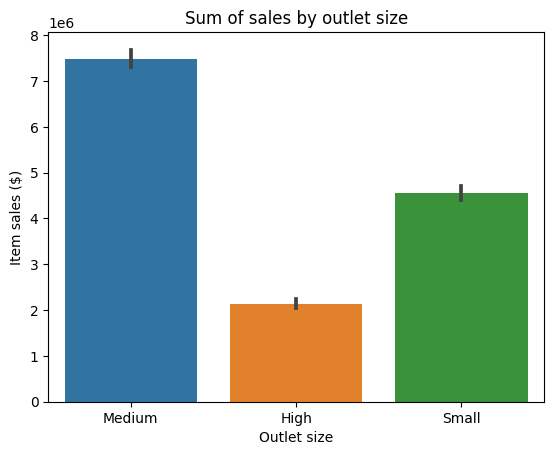

In [44]:
#call sns countplot
g = sns.barplot(x='outlet_size', y='item_outlet_sales', data=df, estimator=np.sum)
#set title
g.set_title('Sum of sales by outlet size')
#set axis labels
plt.xlabel('Outlet size')
plt.ylabel('Item sales ($)')
#save plot
#plt.savefig('store_sum_sales')
#show plot
plt.show()

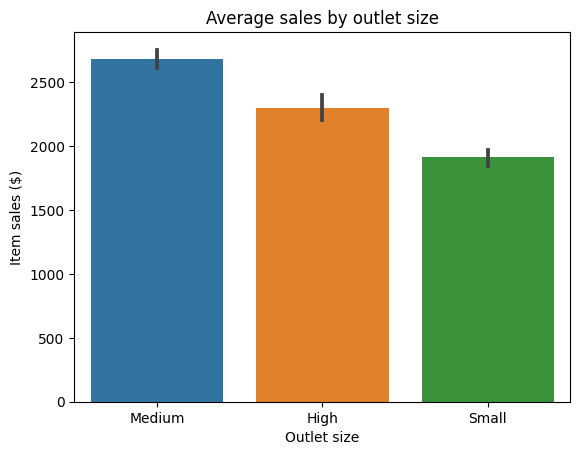

In [45]:
#call sns countplot
g = sns.barplot(x='outlet_size', y='item_outlet_sales', data=df, estimator=np.mean)
#set title
g.set_title('Average sales by outlet size')
#set axis labels
plt.xlabel('Outlet size')
plt.ylabel('Item sales ($)')
#save plot
#plt.savefig('store_avg_sales')
#show plot
plt.show()

On average, medium and large size sell the most but in total its medium and small.

### Outlet type

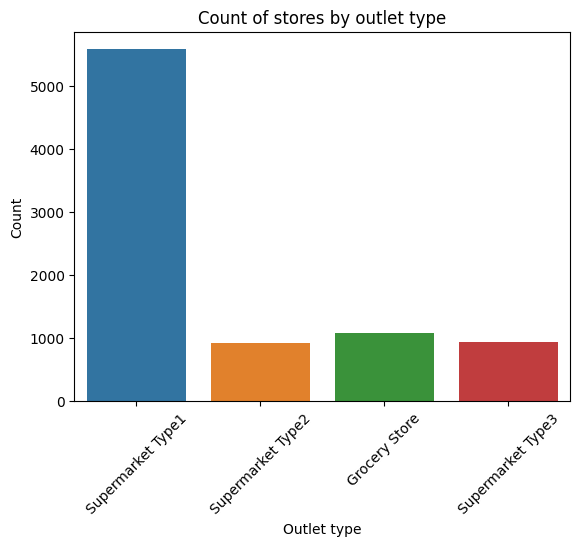

In [46]:
#call sns countplot
g = sns.countplot(x='outlet_type', data=df)
#set title
g.set_title('Count of stores by outlet type')
#set xticks rotation
plt.xticks(rotation=45)
#set axis labels
plt.xlabel('Outlet type')
plt.ylabel('Count')
#save plot
#plt.savefig('store_count_type')
#show plot
plt.show()

A large majority of the outlets are supermarket type1.

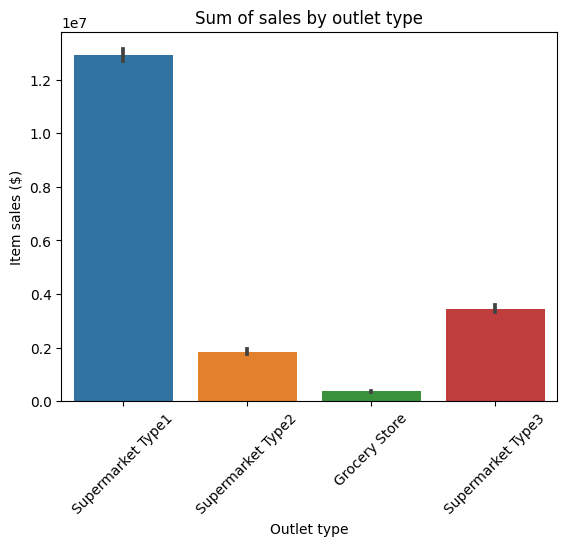

In [47]:
#call sns countplot
g = sns.barplot(x='outlet_type', y='item_outlet_sales', data=df, estimator=np.sum)
#set title
g.set_title('Sum of sales by outlet type')
#set xticks rotation
plt.xticks(rotation=45)
#set axis labels
plt.xlabel('Outlet type')
plt.ylabel('Item sales ($)')
#save plot
#plt.savefig('store_sales_sum_type')
#show plot
plt.show()

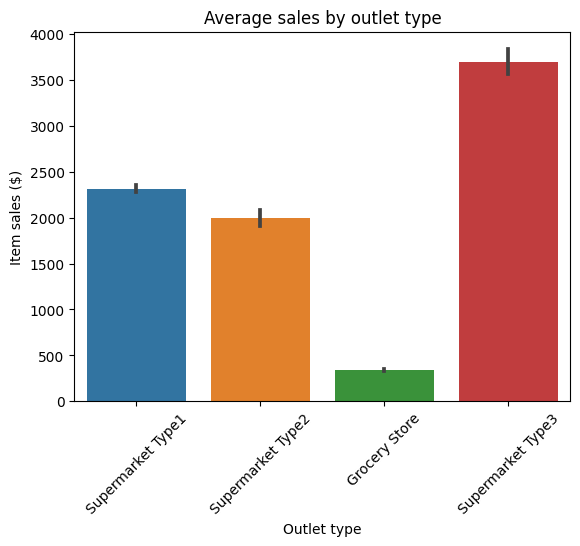

In [48]:
#call sns countplot
g = sns.barplot(x='outlet_type', y='item_outlet_sales', data=df, estimator=np.mean)
#set title
g.set_title('Average sales by outlet type')
#set xticks rotation
plt.xticks(rotation=45)
#set axis labels
plt.xlabel('Outlet type')
plt.ylabel('Item sales ($)')
#save plot
#plt.savefig('store_sales_avg_type')
#show plot
plt.show()

In total, supermarket type1 brings in the most sales but on average supermarket type3.

# Predictive models

## Preprocessing Data

### Relabel ordinal categories

In [49]:
#rename item fat content values
df['item_fat_content']=df['item_fat_content'].replace({'Low Fat': 0, 'Regular': 1}).astype('object')
#call value counts
df['item_fat_content'].value_counts()

0    5517
1    3006
Name: item_fat_content, dtype: int64

In [50]:
#rename items in outlet size
df['outlet_size'] = df['outlet_size'].replace({'Small': 0, 'Medium': 1, 'High': 2}).astype('object')
#call value counts
df['outlet_size'].value_counts()

1.0    2793
0.0    2388
2.0     932
Name: outlet_size, dtype: int64

In [51]:
#call info()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   item_identifier            8523 non-null   object 
 1   item_weight                7060 non-null   float64
 2   item_fat_content           8523 non-null   object 
 3   item_visibility            8523 non-null   float64
 4   item_type                  8523 non-null   object 
 5   item_mrp                   8523 non-null   float64
 6   outlet_identifier          8523 non-null   object 
 7   outlet_establishment_year  8523 non-null   object 
 8   outlet_size                6113 non-null   object 
 9   outlet_location_type       8523 non-null   object 
 10  outlet_type                8523 non-null   object 
 11  item_outlet_sales          8523 non-null   float64
dtypes: float64(4), object(8)
memory usage: 799.2+ KB


### Train Test Split

In [52]:
#save X and y variable
X = df.drop(columns=['item_outlet_sales', 'item_identifier', 'outlet_identifier'])
y= df['item_outlet_sales']
#call train_test_spli#
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Preprocessor

In [53]:
#call instance of StandardScaler and OneHotEncoder
scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown='ignore')
#instance simple inmpute for column selector
freq_imputer = SimpleImputer(strategy='most_frequent')
mean_imputer = SimpleImputer(strategy='mean')
#call column selectors by data type
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')
#make pipelines for each dtype
num_pipe = make_pipeline(mean_imputer, scaler)
cat_pipe = make_pipeline(freq_imputer, ohe)
#save column selectors and preprocessors as tuples
cat_tuple = (cat_pipe, cat_selector)
num_tuple = (num_pipe, num_selector)

In [54]:
#column transformer for each tuple
preprocessor = make_column_transformer(cat_tuple, num_tuple, remainder='drop')
#call preprocessor
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000022E65013700>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000022E65013880>)])

## Decision tree model

### Base model

In [55]:
#call instance of model 
dec_tree = DecisionTreeRegressor(random_state=42)
#call pipeline for preprocessor and model
dec_pipe = make_pipeline(preprocessor, dec_tree)
#fit training data
dec_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000022E65013700>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000022E65013880>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [56]:
#save predictions
y_predict = dec_pipe.predict(X_train)
#save metrics of model
mae = mean_absolute_error(y_train, y_predict)
mse = mean_squared_error(y_train, y_predict)
rmse = np.sqrt(mse)
#print metrics
print(f"MAE: {mae:.20f}")
print(f" MSE: {mse:.30f}")
print(f"RMSE: {rmse:.20f}")

MAE: 0.00000000000000010671
 MSE: 0.000000000000000000000000000024
RMSE: 0.00000000000000492586


The error seams to be extremely low. Either the error is virtually 0 or their is an issue with the model.

### Tuned  model

In [110]:
#call parameters
dec_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('pipeline-1',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore'))]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x0000022E65013700>),
                                   ('pipeline-2',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x0

In [111]:
#save parameters as dictionary
param_grid = {
    'decisiontreeregressor__max_depth': [None, 5, 10],
    'decisiontreeregressor__min_samples_split': [2, 5],
    'decisiontreeregressor__min_samples_leaf': [1, 2]
}
#call gridsearch 
dec_grid = GridSearchCV(dec_pipe, param_grid)
#fit training data 
dec_grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x0000022E65013700>),
                                                                        ('pipeline-2',
                                                                         Pipeline(st...
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x0000022E65013880>)])),
                                       ('decisiontreeregressor',
                                        DecisionTreeRegressor(random_state=42))]),
             param_grid={'decisiontreeregressor__max_depth': [None, 5, 10],
                         'decisiontreeregressor__min_samples_leaf': [1, 2],
                         'decisiontreeregressor__min_samples_split': [2, 5]})

In [112]:
#save predictions
y_predict = dec_grid.predict(X_train)
#save metrics of model
mae = mean_absolute_error(y_train, y_predict)
mse = mean_squared_error(y_train, y_predict)
rmse = np.sqrt(mse)
#print metrics
#print metrics
print(f"MAE: {mae:.2f}")
print(f" MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 762.61
 MSE: 1172122.77
RMSE: 1082.65


The MAE (761.61) is the average difference and predicted and actual values.
MSE (1172122.77) is that number squared and the RMSE (1082.65 is the square root of that. 


## Random forest

### Base model

In [60]:
#create instance of model
rf = RandomForestRegressor(random_state=42)
#create pipeline for model
rf_pipe = make_pipeline(preprocessor, rf)
#fit training data
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000022E65013700>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000022E65013880>)])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [61]:
#save predictions
y_predict = rf_pipe.predict(X_train)
#save metrics of model
mae = mean_absolute_error(y_train, y_predict)
mse = mean_squared_error(y_train, y_predict)
rmse = np.sqrt(mse)
#print metrics
#print metrics
print(f"MAE: {mae:.2f}")
print(f" MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 296.98
 MSE: 183498.95
RMSE: 428.37


MAE average difference between the predicted value and the actual value (296.98). The MSE (183,498) is the square averaged difference the predicted value and the actual value. The RMSE (428) is the square root.

### Tuned model

In [113]:
est_depths = [estimator.get_depth() for estimator in rf.estimators_]
max(est_depths)
#using loop to determine ideal max_depth parameter
depths = range(1, max(est_depths))
scores = pd.DataFrame(index=depths, columns=['Test Score'])
for depth in depths:    
   model = RandomForestRegressor(max_depth=depth)
   pipe = make_pipeline(preprocessor, model)
   pipe.fit(X_train, y_train)
   scores.loc[depth, 'Train Score'] = pipe.score(X_train, y_train)
   scores.loc[depth, 'Test Score'] = pipe.score(X_test, y_test)
   scores.head()

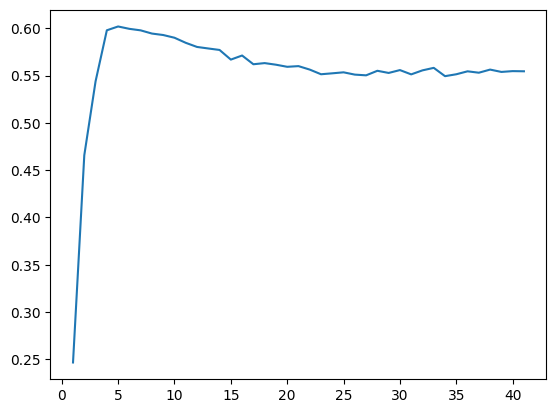

,Test Score,Train Score
5,0.601999,0.610552
6,0.599496,0.624202
4,0.597951,0.596650
7,0.597897,0.642468
8,0.594512,0.665356


In [114]:
#plotting results
plt.plot(scores['Test Score'])
plt.show()
#viewing scores
sorted_scores = scores.sort_values(by='Test Score', ascending=False)
sorted_scores.head()

In [115]:
#loop through N_estimator parameter with 5 max_depth
n_ests = [50, 100, 150, 200, 250]
scores2 = pd.DataFrame(index=n_ests, columns=['Test Score', 'Train Score'])
for n in n_ests:
   model = RandomForestRegressor(max_depth=5, n_estimators=n)
   pipe = make_pipeline(preprocessor, model)
   pipe.fit(X_train, y_train)
   scores2.loc[n, 'Train Score'] = pipe.score(X_train, y_train)
   scores2.loc[n, 'Test Score'] = pipe.score(X_test, y_test)

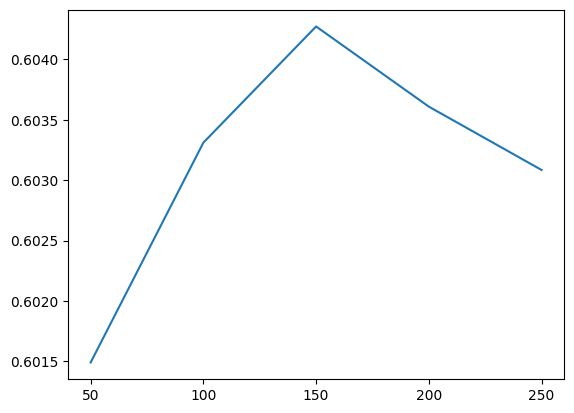

,Test Score,Train Score
150,0.604271,0.610297
200,0.603608,0.610532
100,0.60331,0.610417
250,0.603084,0.610661
50,0.601492,0.610491


In [116]:
#plotting results
plt.plot(scores2['Test Score'])
plt.xticks(n_ests);
plt.show()
#viewing scores
sorted_scores2 = scores2.sort_values(by='Test Score', ascending=False)
sorted_scores2.head()

In [117]:
#final model
rf_final = RandomForestRegressor(max_depth=7, n_estimators=200, random_state=42)
#pipeline with preprocessor
rff_pipe = make_pipeline(preprocessor, rf_final)
#fit training data
rff_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000022E65013700>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000022E65013880>)])),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=7, n_estimators=200,
                                       random_state=42))])

In [118]:
#save predictions
y_predict = rff_pipe.predict(X_train)
#save metrics of model
mae = mean_absolute_error(y_train, y_predict)
mse = mean_squared_error(y_train, y_predict)
rmse = np.sqrt(mse)
#print metrics
#print metrics
print(f"MAE: {mae:.2f}")
print(f" MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 724.74
 MSE: 1057240.99
RMSE: 1028.22


## XGBoost

### Base model

In [68]:
#call instance of model
xgboo = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
#call pipeline for model
xgb_pipe = make_pipeline(preprocessor, xgboo)
#fit training data
xgb_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000022E65013700>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   S...
                              gamma=0, gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.300000012, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=6, max_leaves=0, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=100, n_jobs=0, num_parallel_tree=1,
                              predictor='auto', random_state=42, reg_alpha=0,
                              reg_lambda=1, ...))])

In [69]:
#save predictions
y_predict = xgb_pipe.predict(X_train)
#save metrics of model
mae = mean_absolute_error(y_train, y_predict)
mse = mean_squared_error(y_train, y_predict)
rmse = np.sqrt(mse)
#print metrics
#print metrics
print(f"MAE: {mae:.2f}")
print(f" MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 457.76
 MSE: 403082.89
RMSE: 634.89


In [70]:
# Access feature importances
feature_importance = xgb_pipe.named_steps['xgbregressor'].feature_importances_

# Print feature importance
print('Feature Importance:')
for feature, importance in zip(X.columns, feature_importance):
    print(f'{feature}: {importance}')

Feature Importance:
item_weight: 0.0032266636844724417
item_fat_content: 0.0
item_visibility: 0.005109422840178013
item_type: 0.0039376430213451385
item_mrp: 0.008135724812746048
outlet_establishment_year: 0.0038489806465804577
outlet_size: 0.006368603557348251
outlet_location_type: 0.004086561966687441
outlet_type: 0.005701855290681124


### Tuned model

In [119]:
#call parameters
xgb_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('pipeline-1',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore'))]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x0000022E65013700>),
                                   ('pipeline-2',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x0

In [120]:
#call dictionary of parameters
x_grid = {
    'xgbregressor__n_estimators': [100, 200, 300],
    'xgbregressor__max_depth': [3, 4, 5],
    'xgbregressor__learning_rate': [0.01, 0.1, 0.2]
    
}
#call gridsearchv
xgb_grid = GridSearchCV(xgb_pipe, x_grid)
#fit training data
xgb_grid.fit(X_train, y_train)
#save best parameters
best_xgb = xgb_grid.best_estimator_

In [121]:
#save predictions
y_predict = best_xgb.predict(X_train)
#save metrics of model
mae = mean_absolute_error(y_train, y_predict)
mse = mean_squared_error(y_train, y_predict)
rmse = np.sqrt(mse)
#print metrics
#print metrics
print(f"MAE: {mae:.2f}")
print(f" MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 734.10
 MSE: 1079569.68
RMSE: 1039.02


In [122]:
# Access feature importances
feature_importance = best_xgb.named_steps['xgbregressor'].feature_importances_

# Print feature importance
print('Feature Importance:')
for feature, importance in zip(X.columns, feature_importance):
    print(f'{feature}: {importance}')

Feature Importance:
item_weight: 0.0015420609852299094
item_fat_content: 0.0
item_visibility: 0.0
item_type: 0.00264928606338799
item_mrp: 0.004750597290694714
outlet_establishment_year: 0.002885641297325492
outlet_size: 0.008301385678350925
outlet_location_type: 0.003716213395819068
outlet_type: 0.010065117850899696


# Hypothesis testing

## Do certain outlet types bring in more item sales than others?

Null hypothesis: There is no significant difference between outlet types for item sales?

Alternate hypothesis: There is a significant difference between outlet types for item sales?

Alpha = .05

### Test for outliers

In [75]:
#call value counts on outlet_types
df['outlet_type'].value_counts()

Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: outlet_type, dtype: int64

In [76]:
#call zscores for data
zscores = stats.zscore(df['item_outlet_sales'])
#identify outliers
outliers = df['item_outlet_sales'][abs(zscores)>3]
#print sum on outliers
np.sum(outliers)

761257.7433999999

In [77]:
#call dataframe with no outliers
df2 = df[abs(zscores)<3]
#insoect value counts
df2 = df2.dropna()
#inspect
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4633 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   item_identifier            4633 non-null   object 
 1   item_weight                4633 non-null   float64
 2   item_fat_content           4633 non-null   object 
 3   item_visibility            4633 non-null   float64
 4   item_type                  4633 non-null   object 
 5   item_mrp                   4633 non-null   float64
 6   outlet_identifier          4633 non-null   object 
 7   outlet_establishment_year  4633 non-null   object 
 8   outlet_size                4633 non-null   object 
 9   outlet_location_type       4633 non-null   object 
 10  outlet_type                4633 non-null   object 
 11  item_outlet_sales          4633 non-null   float64
dtypes: float64(4), object(8)
memory usage: 470.5+ KB


In [78]:
#group data 
grouped_data = [group['item_outlet_sales'] for name, group in df2.groupby('outlet_type')]
#inspect
grouped_data

[0       3735.1380
 2       2097.2700
 4        994.7052
 6        343.5528
 10      1516.0266
           ...    
 8513     595.2252
 8517    3608.6360
 8518    2778.3834
 8520    1193.1136
 8522     765.6700
 Name: item_outlet_sales, Length: 3705, dtype: float64,
 1        443.4228
 5        556.6088
 16      1621.8888
 31      2741.7644
 32      3068.0064
           ...    
 8506    3944.8650
 8511    4207.8560
 8515    1571.2880
 8516     858.8820
 8521    1845.5976
 Name: item_outlet_sales, Length: 928, dtype: float64]

### Test for normality

In [79]:
# Shapiro-Wilk test for normality
for group in grouped_data:
    stat, p_value = shapiro(group)
    print(f"Shapiro-Wilk p-value: {p_value<.05}")

Shapiro-Wilk p-value: True
Shapiro-Wilk p-value: True


The pvalue is less than .05, so we can reject the null hypothesis the data is distributed normally

### Test of equal variance

In [80]:
#call levene test
stat, p_value = levene(*grouped_data)
#print results
print(f"Levene's p-value: {p_value<.05}")

Levene's p-value: True


The pvalue is less than .05, so we can reject the null hypothesis the samples have equal variance.

### ANOVA test

In [81]:
# Perform Welch's ANOVA
pg.welch_anova(dv='item_outlet_sales', between='outlet_type', data=df2)

,Source,ddof1,ddof2,F,p-unc,np2
0,outlet_type,1,1502.232932,38.780276,6.143052e-10,0.007676


In [82]:
"{:.10f}".format(float("6.143052e-10"))

'0.0000000006'

The p-value is lest than 0.5 so we can reject the null hypothesis there is no difference between sales by outlet type.  

## Do different outlet sizes bring in more item sales?

Null hypothesis: There is no significant difference between outlet sizes for item sales.

Alternate hypothesis: There is a significant difference between outlet sizes for item sales.

Alpha = .05


### Test for outliers

In [83]:
#call value counts on outlet_types
df['outlet_size'].value_counts()

1.0    2793
0.0    2388
2.0     932
Name: outlet_size, dtype: int64

In [84]:
#call df2 
df2.head()

,item_identifier,item_weight,item_fat_content,item_visibility,item_type,item_mrp,outlet_identifier,outlet_establishment_year,outlet_size,outlet_location_type,outlet_type,item_outlet_sales
0,FDA15,9.300,0,0.016047,Dairy,249.8092,OUT049,1999,1.0,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,1,0.019278,Soft Drinks,48.2692,OUT018,2009,1.0,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,0,0.016760,Meat,141.6180,OUT049,1999,1.0,Tier 1,Supermarket Type1,2097.2700
4,NCD19,8.930,0,0.000000,Household,53.8614,OUT013,1987,2.0,Tier 3,Supermarket Type1,994.7052
5,FDP36,10.395,1,0.000000,Baking Goods,51.4008,OUT018,2009,1.0,Tier 3,Supermarket Type2,556.6088


We created a dataframe with no outliers earlier, no test is needed

### Test for normality

In [85]:
#group data 
grouped_data = [group['item_outlet_sales'] for name, group in df2.groupby('outlet_size')]
#inspect
grouped_data

[11      2187.1530
 13      2145.2076
 15      1547.3192
 19      2748.4224
 22      1587.2672
           ...    
 8510    7182.6504
 8513     595.2252
 8517    3608.6360
 8520    1193.1136
 8522     765.6700
 Name: item_outlet_sales, Length: 1851, dtype: float64,
 0       3735.1380
 1        443.4228
 2       2097.2700
 5        556.6088
 10      1516.0266
           ...    
 8506    3944.8650
 8511    4207.8560
 8515    1571.2880
 8516     858.8820
 8521    1845.5976
 Name: item_outlet_sales, Length: 1855, dtype: float64,
 4        994.7052
 6        343.5528
 14      1977.4260
 20      3775.0860
 27       308.9312
           ...    
 8462    1494.0552
 8466     673.7896
 8484    2324.9736
 8512    2479.4392
 8518    2778.3834
 Name: item_outlet_sales, Length: 927, dtype: float64]

In [86]:
# Shapiro-Wilk test for normality
for group in grouped_data:
    stat, p_value = shapiro(group)
    print(f"Shapiro-Wilk p-value: {p_value<.05}")

Shapiro-Wilk p-value: True
Shapiro-Wilk p-value: True
Shapiro-Wilk p-value: True


The p-value is less 0.05, which means we can reject the null hypothesis that the sales are distributed normally.

### Test for equal variance

In [87]:
#call levene test
stat, p_value = levene(*grouped_data)
#print results
print(f"Levene's p-value: {p_value<.05}")

Levene's p-value: False


The p-value in not less than .05. Meaning we fail to reject the null hypothesis that our samples have equal variance 

### Anova test

In [88]:
#call f_onewat
result = f_oneway(*grouped_data)
#call if else statement to see result
# Check the p-value with if else statement
if result.pvalue < 0.05:
    print("There is a significant difference in item outlet sales.")
else:
    print("There is no significant difference in item outlet sales.")

There is a significant difference in item outlet sales.


The pvalue is less than .05, so reject the null hypothesis that there is no difference between item sales by outlet size.

## Is there a difference between sales by item type?

Null hypothesis: There is no significant difference between item types for item sales?

Alternate hypothesis: There is a significant difference between item types for item sales?

Alpha = .05

### Test for outliers

In [89]:
#call value counts on outlet_types
df2['item_type'].value_counts()

Fruits and Vegetables    667
Snack Foods              654
Household                498
Frozen Foods             476
Dairy                    375
Canned                   360
Baking Goods             350
Health and Hygiene       275
Soft Drinks              241
Meat                     221
Breads                   132
Hard Drinks              116
Others                    91
Starchy Foods             86
Breakfast                 58
Seafood                   33
Name: item_type, dtype: int64

In [90]:
#call df2 
df2.head()

,item_identifier,item_weight,item_fat_content,item_visibility,item_type,item_mrp,outlet_identifier,outlet_establishment_year,outlet_size,outlet_location_type,outlet_type,item_outlet_sales
0,FDA15,9.300,0,0.016047,Dairy,249.8092,OUT049,1999,1.0,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,1,0.019278,Soft Drinks,48.2692,OUT018,2009,1.0,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,0,0.016760,Meat,141.6180,OUT049,1999,1.0,Tier 1,Supermarket Type1,2097.2700
4,NCD19,8.930,0,0.000000,Household,53.8614,OUT013,1987,2.0,Tier 3,Supermarket Type1,994.7052
5,FDP36,10.395,1,0.000000,Baking Goods,51.4008,OUT018,2009,1.0,Tier 3,Supermarket Type2,556.6088


We created a dataframe with no outliers earlier, no test is needed

### Test for normality

In [91]:
#group data 
grouped_data = [group['item_outlet_sales'] for name, group in df2.groupby('item_type')]
#inspect
grouped_data

[5        556.6088
 48      2576.6460
 71       599.2200
 106     1794.3310
 156      262.3252
           ...    
 8381    4739.8302
 8382    3103.9596
 8416     925.4620
 8441     777.6544
 8515    1571.2880
 Name: item_outlet_sales, Length: 350, dtype: float64,
 169      619.1940
 303     1134.5232
 350     1869.5664
 402     6911.0040
 667     1325.6078
           ...    
 8191    1286.3256
 8240     882.1850
 8334    1099.2358
 8370     871.5322
 8413    1691.1320
 Name: item_outlet_sales, Length: 132, dtype: float64,
 15      1547.3192
 17       718.3982
 567     1561.9668
 629     1640.5312
 812     3617.9572
 1035    2190.4820
 1069    4843.6950
 1492     201.0716
 1521     262.3252
 1562    3101.2964
 1806     171.7764
 1848    6006.1818
 1907     801.6232
 2283    1845.5976
 2532    3339.6528
 2856    1095.2410
 3090    2541.3586
 3328    1398.1800
 3547    1284.9940
 3596    2826.9868
 3673    2460.7968
 3683    3528.7400
 3909    2184.4898
 3932    1145.1760
 3939    1151.16

In [92]:
# Shapiro-Wilk test for normality
for group in grouped_data:
    stat, p_value = shapiro(group)
    print(f"Shapiro-Wilk p-value: {p_value<.05}")

Shapiro-Wilk p-value: True
Shapiro-Wilk p-value: True
Shapiro-Wilk p-value: True
Shapiro-Wilk p-value: True
Shapiro-Wilk p-value: True
Shapiro-Wilk p-value: True
Shapiro-Wilk p-value: True
Shapiro-Wilk p-value: True
Shapiro-Wilk p-value: True
Shapiro-Wilk p-value: True
Shapiro-Wilk p-value: True
Shapiro-Wilk p-value: True
Shapiro-Wilk p-value: False
Shapiro-Wilk p-value: True
Shapiro-Wilk p-value: True
Shapiro-Wilk p-value: True


The p-value is less 0.05, which means we can reject the null hypothesis that the sales are distributed normally.

### Test for equal variance

In [93]:
#call levene test
stat, p_value = levene(*grouped_data)
#print results
print(f"Levene's p-value: {p_value<.05}")

Levene's p-value: False


The p-value in not less than .05. Meaning we fail to reject the null hypothesis that our samples have equal variance 

### Anova test

In [94]:
#call f_onewat
result = f_oneway(*grouped_data)
#call if else statement to see result
# Check the p-value with if else statement
if result.pvalue < 0.05:
    print("There is a significant difference in item outlet sales.")
else:
    print("There is no significant difference in item outlet sales.")

There is a significant difference in item outlet sales.


The value is less than .05, meaning we reject the null hypothesis that there is no difference between item sales by item type.

## Is there a difference in item sales by fat content.

Null hypothesis: There is no significant difference between fat content for item sales?

Alternate hypothesis: There is a significant difference between fat content for item sales?

Alpha = .05

In [95]:
#call value counts
df2['item_fat_content'].value_counts()

0    2993
1    1640
Name: item_fat_content, dtype: int64

In [96]:
#filter low fat sample
low_fat = df2[df2['item_fat_content']==0]
#filter reg fat sample
reg_fat = df2[df2['item_fat_content']==1]
#inspect filtered data 
display(low_fat.head(2), reg_fat.head(2))

,item_identifier,item_weight,item_fat_content,item_visibility,item_type,item_mrp,outlet_identifier,outlet_establishment_year,outlet_size,outlet_location_type,outlet_type,item_outlet_sales
0,FDA15,9.3,0,0.016047,Dairy,249.8092,OUT049,1999,1.0,Tier 1,Supermarket Type1,3735.138
2,FDN15,17.5,0,0.016760,Meat,141.6180,OUT049,1999,1.0,Tier 1,Supermarket Type1,2097.270


,item_identifier,item_weight,item_fat_content,item_visibility,item_type,item_mrp,outlet_identifier,outlet_establishment_year,outlet_size,outlet_location_type,outlet_type,item_outlet_sales
1,DRC01,5.920,1,0.019278,Soft Drinks,48.2692,OUT018,2009,1.0,Tier 3,Supermarket Type2,443.4228
5,FDP36,10.395,1,0.000000,Baking Goods,51.4008,OUT018,2009,1.0,Tier 3,Supermarket Type2,556.6088


In [97]:
#save only item outlet sales
low_fat=low_fat['item_outlet_sales']
reg_fat=reg_fat['item_outlet_sales']
#inspect
display(low_fat.head(2), reg_fat.head(2))

0    3735.138
2    2097.270
Name: item_outlet_sales, dtype: float64

1    443.4228
5    556.6088
Name: item_outlet_sales, dtype: float64

### Test for outliers

#### Low fat group

In [98]:
#call zscore
zscores = stats.zscore(low_fat)
#save outliers as variable
outliers = abs(zscores)>3
#sum outliers
np.sum(outliers)

23

In [99]:
#saving data with no outliers
low_fat = low_fat[(np.abs(stats.zscore(low_fat)) < 3)]

In [100]:
#inspect data
low_fat.head()

0     3735.1380
2     2097.2700
4      994.7052
10    1516.0266
14    1977.4260
Name: item_outlet_sales, dtype: float64

#### Regular fat group

In [101]:
#call zscore
zscores = stats.zscore(reg_fat)
#save outliers as variable
outliers = abs(zscores)>3
#sum outliers
np.sum(outliers)

9

In [102]:
#saving data with no outliers
reg_fat = reg_fat[(np.abs(stats.zscore(reg_fat)) < 3)]

In [103]:
#inspect data
reg_fat.head()

1      443.4228
5      556.6088
6      343.5528
11    2187.1530
12    1589.2646
Name: item_outlet_sales, dtype: float64

### Test for normality

#### Low fat group

In [104]:
#call normal test
result = stats.normaltest(low_fat)
#print result
print(result)
#call boolean to see significance
result.pvalue <0.05

NormaltestResult(statistic=267.0905629847387, pvalue=1.0046647475030964e-58)


True

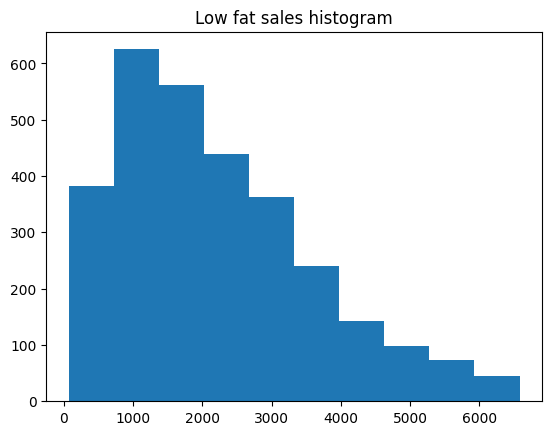

In [105]:
#call histogram
plt.hist(low_fat)
#call title
plt.title('Low fat sales histogram')
#show plot
plt.show()

Our pvalue is less than 0.05, so we reject the null hypothesis that the data is normally distributed.

#### Regular fat group

In [106]:
#call normal test
result = stats.normaltest(reg_fat)
#print result
print(result)
#call boolean to see significance
result.pvalue <0.05

NormaltestResult(statistic=127.96067376623644, pvalue=1.6356589009902375e-28)


True

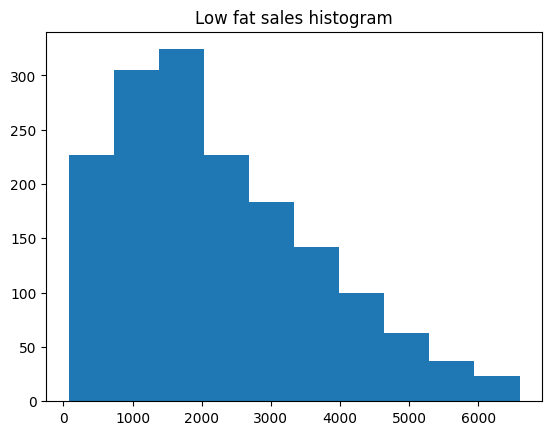

In [107]:
#call histogram
plt.hist(reg_fat)
#call title
plt.title('Low fat sales histogram')
#show plot
plt.show()

Our pvalue is less than 0.05, so we reject the null hypothesis that the data is normally distributed.

### Test for equal variance

In [108]:
#save results of levene test
result = stats.levene(low_fat, reg_fat)
#print result
print(result)
#call boolean to see significance
result.pvalue < .05

LeveneResult(statistic=0.9483928704657959, pvalue=0.3301799340022674)


False

The pvalue is greater than 0.05, so we fail to reject the null hypothesis that the data has equal variance.

### T-test

In [109]:
#save results of ttest
result = stats.ttest_ind(low_fat, reg_fat)
#print result
if result.pvalue < 0.05:
    print("There is a significant difference in item outlet sales.")
else:
    print("There is no significant difference in item outlet sales.")

There is no significant difference in item outlet sales.


The pvalue is not less than 0.05, meaning we fail to reject the null hypothesis there is no significant difference between item sales and item types.